In [1]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from numpy import dot
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.config.run_functions_eagerly(True)

print(tf.__version__)

import re
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2.9.0


In [2]:
#Unmark with every new session
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Unmark with every new session
# %cd /content/drive/My Drive/Dataset_BUSI_with_GT
#!ls

In [4]:
Image_Mask_Dict = {'img' : [], 'mask' : []}

def load_data(images_and_masks=None, img_path=None, mask_path=None, shape=256, threshold=0.5):
    img_names = os.listdir(img_path)
    img_dict = {}

    for img_name in img_names:
        prefix = img_name.split(')')[0]
        img_dict.setdefault(prefix, {})[img_name.endswith('_mask.png')] = img_name

    for prefix, files in img_dict.items():
        img_file = os.path.join(img_path, files[False])
        mask_file = os.path.join(mask_path, files[True])
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)  # read image as grayscale
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        # convert mask to binary using thresholding
        ret, mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)

        img = cv2.resize(img, (shape, shape), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (shape, shape), interpolation=cv2.INTER_LINEAR)

        images_and_masks['img'].append(img)
        images_and_masks['mask'].append(mask)

        # print range of mask pixel values
        # print(f"Mask pixel range: {np.min(mask)}, {np.max(mask)}")

    return images_and_masks

In [5]:
# loading benign and malignant samples
Image_Mask_Dict = load_data( Image_Mask_Dict, img_path = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/malignant'
                          , mask_path = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/malignant'
                          , shape = 256)


Image_Mask_Dict = load_data( Image_Mask_Dict, img_path = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/benign'
                          , mask_path = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/benign'
                          , shape = 256)

In [6]:
# print(Image_Mask_Dict['img'])

In [7]:
# print(Image_Mask_Dict['mask'])

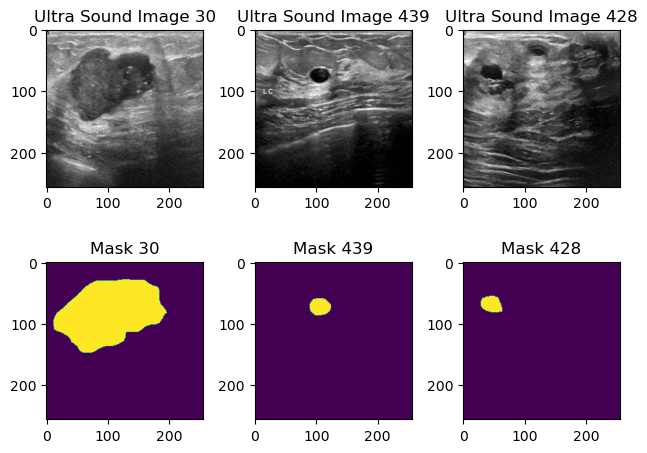

In [8]:
for i in range(3):
    index = random.randint(0, len(Image_Mask_Dict['img'])-1)  # generate a random index
    plt.subplot(2, 3, i+1)
    gray_image = plt.imshow(Image_Mask_Dict['img'][index], cmap='gray')
    plt.title(f'Ultra Sound Image {index+1}')

    plt.subplot(2, 3, i+4)
    plt.imshow(Image_Mask_Dict['mask'][index])
    plt.title(f'Mask {index+1}')

plt.tight_layout()
plt.show()

In [9]:
# convert data to numpy arrays
X = np.array(Image_Mask_Dict['img'])
y = np.array(Image_Mask_Dict['mask'])

X = X / 255.0
y = y / 255.0

# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# check the shapes of the resulting arrays
print('Training images shape:', X_train.shape)
print('Validation images shape:', X_val.shape)
print('Testing images shape:', X_test.shape)
print('Training masks shape:', y_train.shape)
print('Validation masks shape:', y_val.shape)
print('Testing masks shape:', y_test.shape)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_val.shape[0] == y_val.shape[0]


print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

Training images shape: (413, 256, 256)
Validation images shape: (104, 256, 256)
Testing images shape: (130, 256, 256)
Training masks shape: (413, 256, 256)
Validation masks shape: (104, 256, 256)
Testing masks shape: (130, 256, 256)
There are 413 images in training set
There are 104 images in validation set
There are 130 images in test set


In [10]:
# print(X_train)

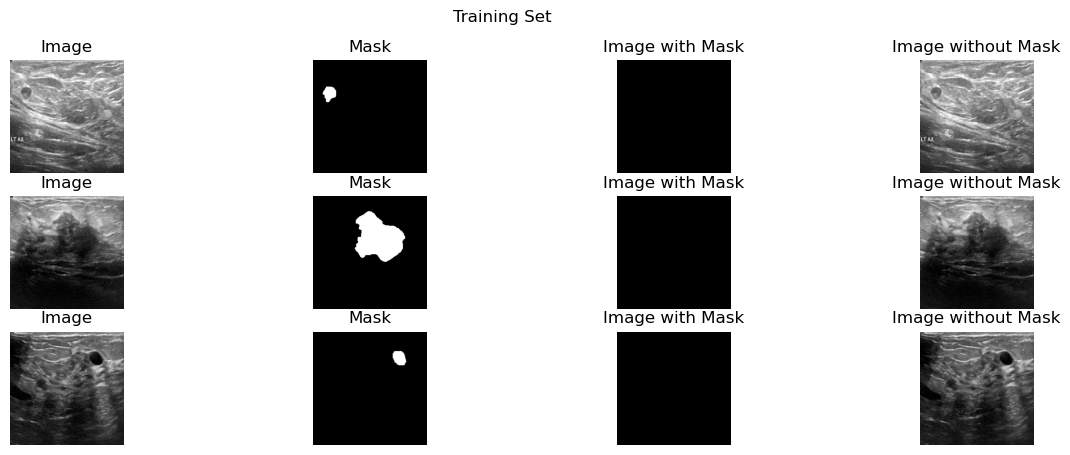

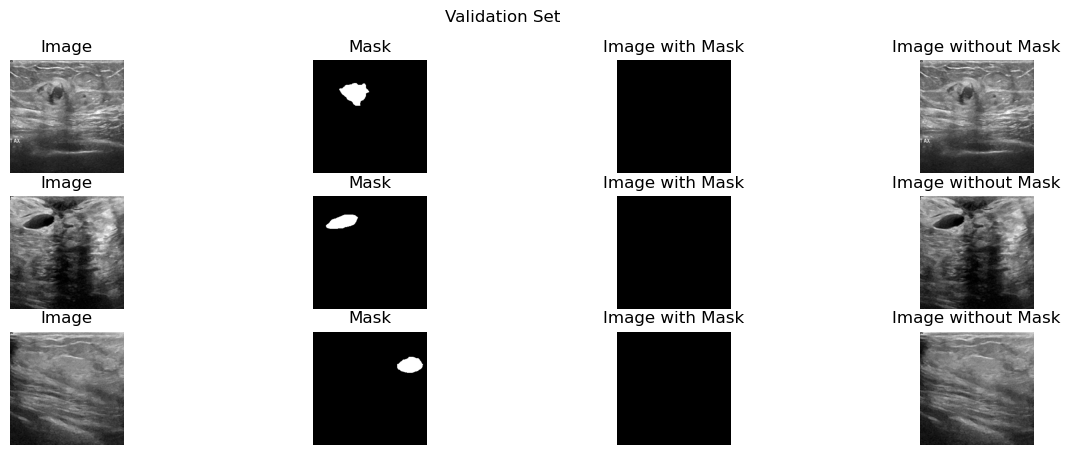

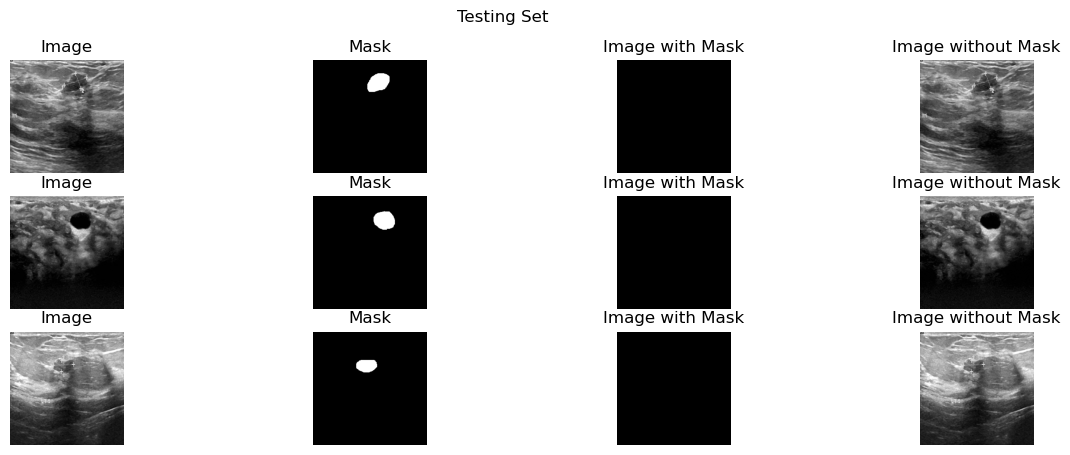

In [11]:
# visualize 3 random images along with their masks for each set
sets = {'Training': (X_train, y_train), 'Validation': (X_val, y_val), 'Testing': (X_test, y_test)}

for set_name, (images, masks) in sets.items():
    plt.figure(figsize=(15,5))
    plt.suptitle(f'{set_name} Set')
    for i in range(3):
        index = np.random.randint(images.shape[0])
        plt.subplot(3, 4, i*4+1)
        plt.imshow(images[index], cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(3, 4, i*4+2)
        plt.imshow(masks[index], cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        masked_image = cv2.merge([images[index], images[index], images[index]]) * cv2.merge([masks[index], masks[index], masks[index]])
        plt.subplot(3, 4, i*4+3)
        plt.imshow(masked_image, cmap='gray')
        plt.title('Image with Mask')
        plt.axis('off')
        unmasked_image = cv2.merge([images[index], images[index], images[index]]) * cv2.merge([(1-masks[index]), (1-masks[index]), (1-masks[index])])
        plt.subplot(3, 4, i*4+4)
        plt.imshow(unmasked_image, cmap='gray')
        plt.title('Image without Mask')
        plt.axis('off')
    plt.show()

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1-y_true) * y_pred)
    fn = K.sum(y_true * (1-y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1.0 - score

def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE =  K.binary_crossentropy(targets, inputs)
    intersection = K.sum(dot(targets, inputs))  
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

In [13]:
def get_unet(input_shape=(None, None, 1),
             num_classes=2):
    inputs = Input(shape=input_shape)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)


    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)


    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)


    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)


    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)


    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)


    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)


    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)


    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)


    classify = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.0005),loss=DiceBCELoss, metrics=[dice_coef])
    return model

In [14]:
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 100
SMOOTH = 1.
STEPS_PER_EPOCH = 10
# define model
model = get_unet()

# Train model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1, batch_size=BATCH_SIZE)

# Evaluate model on test data
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

Metal device set to: Apple M1 Max
Epoch 1/100


/Users/syn/miniforge3/envs/env_tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-04-20 15:56:42.178569: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 20s 2s/step - loss: 1.7549 - dice_coef: 0.0174 - val_loss: 1.3293 - val_dice_coef: 0.0515
Epoch 2/100
10/10 [==============================] - 19s 2s/step - loss: 1.6585 - dice_coef: 0.0182 - val_loss: 1.3018 - val_dice_coef: 0.0592
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 1.6330 - dice_coef: 0.0190 - val_loss: 1.2759 - val_dice_coef: 0.0688
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 1.6085 - dice_coef: 0.0201 - val_loss: 1.4873 - val_dice_coef: 0.0276
Epoch 5/100
10/10 [==============================] - 19s 2s/step - loss: 1.5843 - dice_coef: 0.0211 - val_loss: 1.5330 - val_dice_coef: 0.0242
Epoch 6/100
10/10 [==============================] - 19s 2s/step - loss: 1.5595 - dice_coef: 0.0228 - val_loss: 1.5754 - val_dice_coef: 0.0221
Epoch 7/100
10/10 [==============================] - 18s 2s/step - loss: 1.5346 - dice_coef: 0.0239 - val_loss: 1.5139 - val_dice_coef: 0.0258
Epoch 8/100

Test Dice Coef: 0.9928091168403625


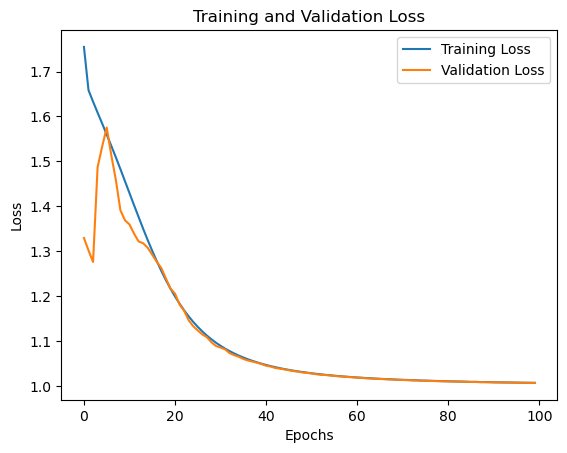

In [15]:
print('Test Dice Coef:', results[1])

# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

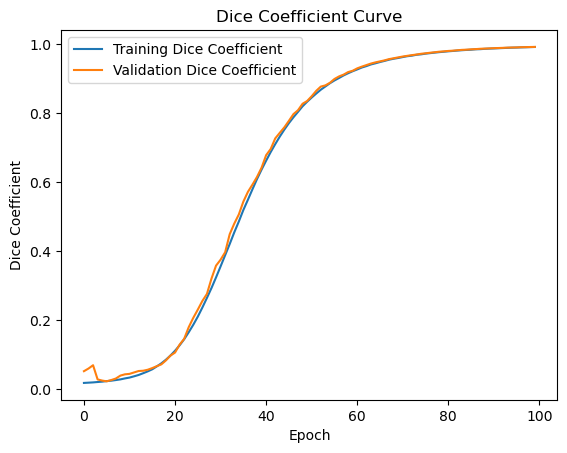

In [16]:
# Plot the dice coefficient curve
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient Curve')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

1/1 [==============================] - 0s 365ms/step


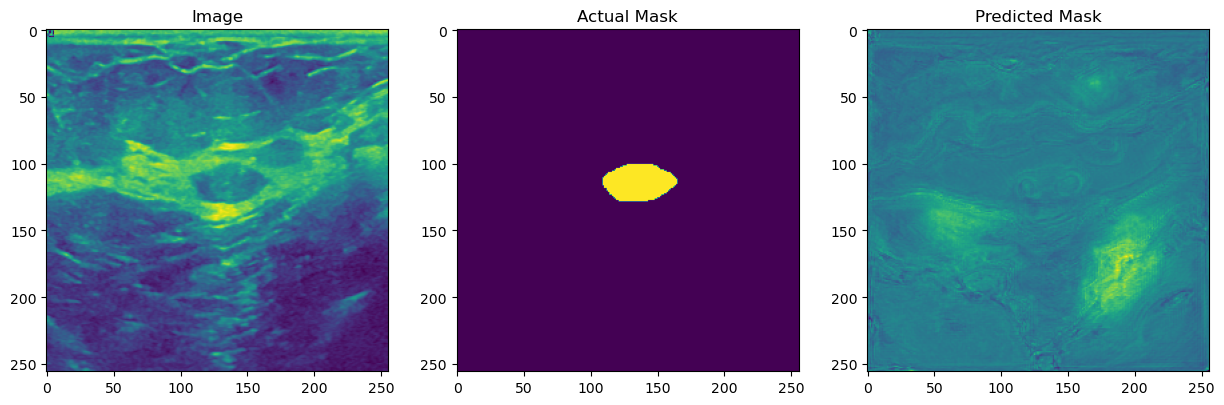

1/1 [==============================] - 0s 60ms/step


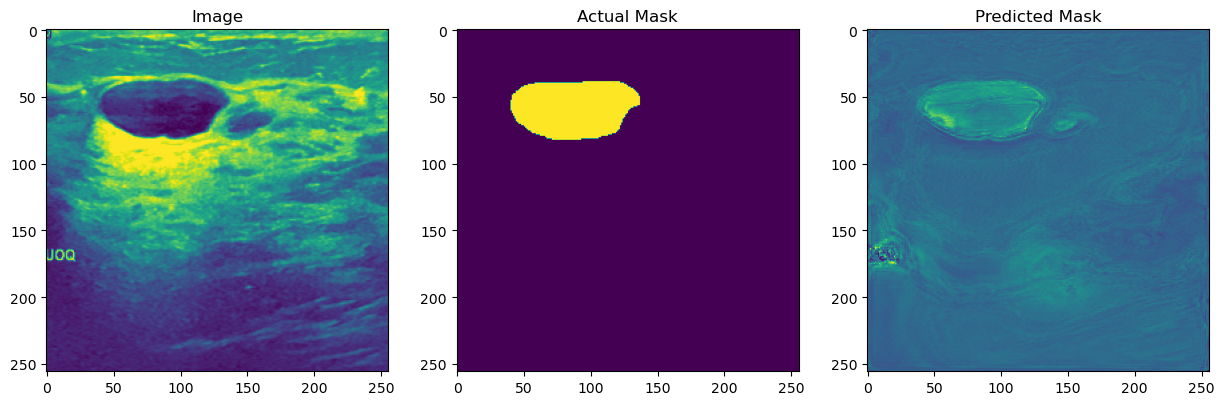

1/1 [==============================] - 0s 58ms/step


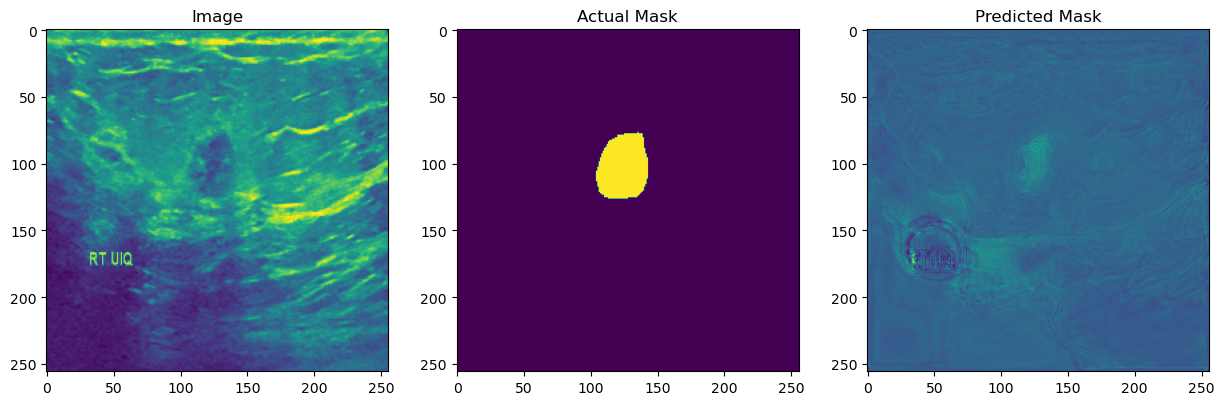

1/1 [==============================] - 0s 58ms/step


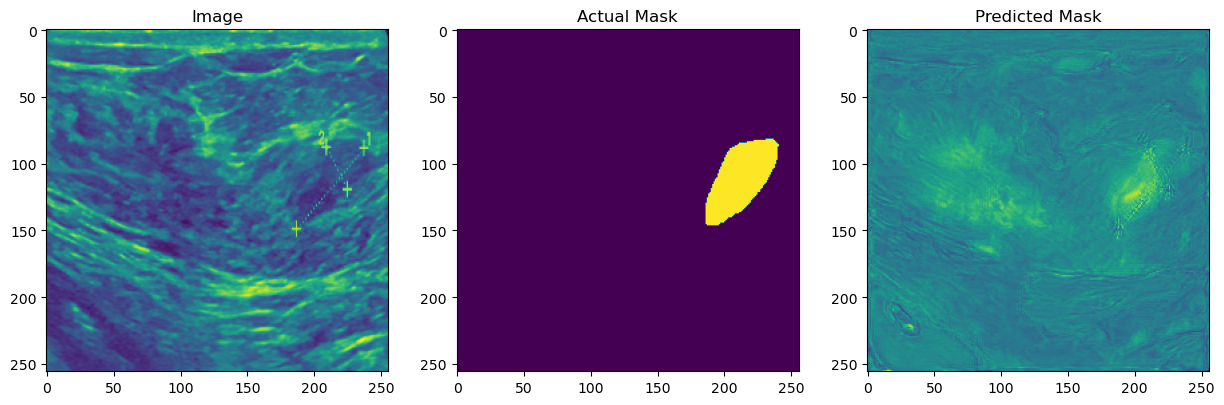

1/1 [==============================] - 0s 53ms/step


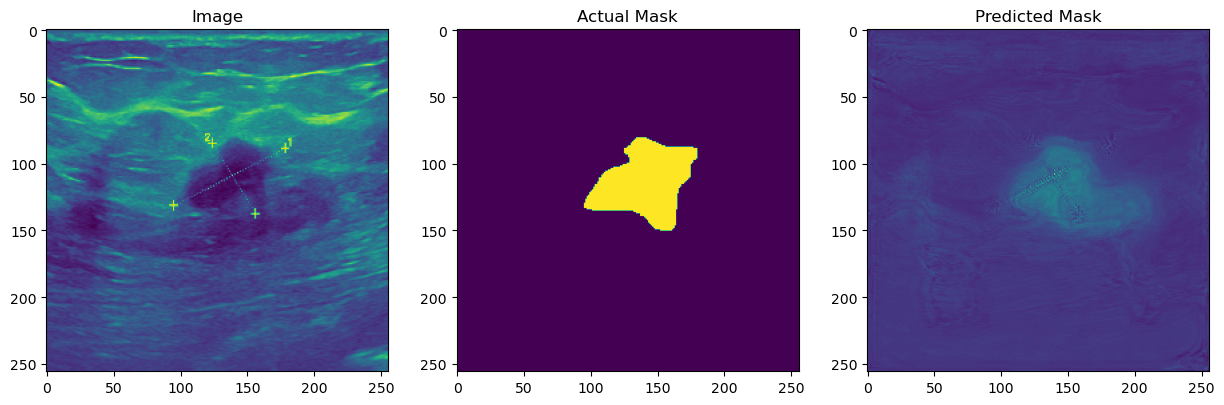

In [17]:
# Generate visualizations of the image, actual mask, and predicted mask
for i in range(5):
    image = X_test[i]
    mask = y_test[i]
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Actual Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')
    plt.show()